In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import pickle

# Przygotowanie danych

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Usuniecie kolumny 'Oldpeak'

In [3]:
df.drop(['Oldpeak'], axis=1, inplace=True)

### Sprawdzenie, czy sa braki w danych

In [4]:
df.isnull().any()

Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
ST_Slope          False
HeartDisease      False
dtype: bool

### Znalezienie zmiennych kategorycznych

In [5]:
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
categorical_cols

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

### Zakodowanie zmiennych kategorycznych 

In [6]:
le_dict = {}
df_copy = df.copy()

for col in categorical_cols:

    le_dict[col] = LabelEncoder()
    le_dict[col].fit(df[col])
    
    print('Column: {} - Classes: {} - Labels: {}'.format(
        col, le_dict[col].classes_, le_dict[col].transform(le_dict[col].classes_)))
    
    df[col] = le_dict[col].transform(df[col])

Column: Sex - Classes: ['F' 'M'] - Labels: [0 1]
Column: ChestPainType - Classes: ['ASY' 'ATA' 'NAP' 'TA'] - Labels: [0 1 2 3]
Column: RestingECG - Classes: ['LVH' 'Normal' 'ST'] - Labels: [0 1 2]
Column: ExerciseAngina - Classes: ['N' 'Y'] - Labels: [0 1]
Column: ST_Slope - Classes: ['Down' 'Flat' 'Up'] - Labels: [0 1 2]


In [7]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,2,0
1,49,0,2,160,180,0,1,156,0,1,1
2,37,1,1,130,283,0,2,98,0,2,0
3,48,0,0,138,214,0,1,108,1,1,1
4,54,1,2,150,195,0,1,122,0,2,0


# Trenowanie modelu

### Podzial zbioru na X i y

In [8]:
X = df.drop('HeartDisease', axis=1).copy()
y = df['HeartDisease'].copy()

### Optymalizacja hiperparametrow z wykorzystaniem walidacji krzyzowej 5-krotnej

In [9]:
mlp = MLPClassifier(random_state=123, activation='logistic', max_iter=1000)
mlp_params = {
    'hidden_layer_sizes': [(100,), (100, 50), (50,)],
    'solver': ['sgd', 'adam'],
}

mlp_search = GridSearchCV(mlp, mlp_params, scoring='accuracy')
mlp_search = mlp_search.fit(X, y)

Dokladnosc modelu dla kazdej sprawdzanej kombinacji parametrow:

In [30]:
grid_search_results = pd.DataFrame(mlp_search.cv_results_)
columns = [i for i in grid_search_results.columns if i.startswith('param_')]
columns.extend(['mean_test_score', 'rank_test_score'])
grid_search_results = grid_search_results[columns].sort_values(by='rank_test_score').reset_index(drop=True)
grid_search_results

,param_hidden_layer_sizes,param_solver,mean_test_score,rank_test_score
0,"(50,)",adam,0.816958,1
1,"(100,)",adam,0.815859,2
2,"(100, 50)",adam,0.811505,3
3,"(50,)",sgd,0.701526,4
4,"(100,)",sgd,0.700416,5
5,"(100, 50)",sgd,0.663489,6


In [10]:
mlp_search.best_score_

0.8169577096697551

In [11]:
mlp_search.best_params_

{'hidden_layer_sizes': (50,), 'solver': 'adam'}

### Budowa modelu wykorzystujac parametry dajace najwyzsza dokladnosc

In [12]:
model = MLPClassifier(**mlp_search.best_params_, random_state=123, activation='logistic', max_iter=1000)
model.fit(X, y)

MLPClassifier(activation='logistic', hidden_layer_sizes=(50,), max_iter=1000,
              random_state=123)

# Testowanie modelu

In [13]:
y_pred = model.predict(X)

### Classification report:

In [14]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       410
           1       0.89      0.86      0.87       508

    accuracy                           0.86       918
   macro avg       0.86      0.86      0.86       918
weighted avg       0.86      0.86      0.86       918



### Confusion matrix:

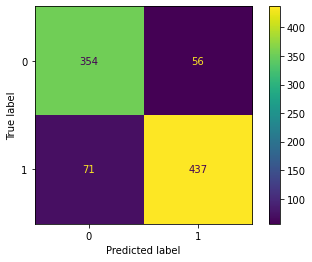

In [15]:
conf_matrix_disp = ConfusionMatrixDisplay(confusion_matrix(y, y_pred))
conf_matrix_disp.plot()

# Zapisanie modelu i label encoder do pickle

In [16]:
pickle.dump(model, open('model.pkl', "wb"))
pickle.dump(le_dict, open('le_dict.pkl', "wb"))

# Przykladowe uzycie modelu

In [17]:
model_pkl = pickle.load(open('model.pkl', 'rb'))
le_dict_pkl = pickle.load(open('le_dict.pkl', 'rb'))

In [18]:
model_pkl

MLPClassifier(activation='logistic', hidden_layer_sizes=(50,), max_iter=1000,
              random_state=123)

In [19]:
le_dict_pkl

{'Sex': LabelEncoder(),
 'ChestPainType': LabelEncoder(),
 'RestingECG': LabelEncoder(),
 'ExerciseAngina': LabelEncoder(),
 'ST_Slope': LabelEncoder()}

### Wybranie wiersza z danych bez 'Oldpeak'

In [20]:
selected_row = df_copy.iloc[[10]].drop(['HeartDisease'], axis=1)
selected_row

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,ST_Slope
10,37,F,NAP,130,211,0,Normal,142,N,Up


### Kodowanie zmiennych kategorycznych:

In [21]:
for col in le_dict_pkl.keys():
    selected_row[col] = le_dict_pkl[col].transform(selected_row[col])

In [22]:
selected_row

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,ST_Slope
10,37,0,2,130,211,0,1,142,0,2


### Predykcja:

Predykcja musi byc robiona na pd.DataFrame, wiec jesli np dane sa wstawiane do slownika to trzeba zrobic: <br>

    slownik_z_danymi = {
        'kolumna1': [jakas wartosc],
        'kolumna2': [jakas wartosc],
              ....
        }
    dane_do_predict = pd.DataFrame.from_dict(slownik_z_danymi)

In [23]:
prediction = model_pkl.predict(selected_row)[0]

In [24]:
print("Predicted value = {}".format(prediction))
print("Real value = {}".format(df_copy.iloc[[10]]['HeartDisease'].item()))

Predicted value = 0
Real value = 0
